# COMP47590: Advanced Machine Learning
# Assignment 1: Building Stacked Ensembles

Name(s): Abdul Kuddus Sunbul

Student Number(s): 16203822

## Import Packages Etc

In [1]:
from IPython.display import display, HTML, Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score

%matplotlib inline
#%qtconsole

In [2]:
# creating necessary dictionaries
model_test_accuracy_comparisons = dict()
model_cv_scores_for_mean_comparisons = dict()
model_cv_scores_for_std_comparisons = dict()

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [3]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [4]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer.
    A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Test the StackedEnsembleClassifier

Perform a simple test using the StackedEnsembleClassifier on the Iris dataset

Perform a cross validation experiment

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleClassifier()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.96      0.98        50
          2       0.96      1.00      0.98        50

avg / total       0.99      0.99      0.99       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


In [6]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


In [7]:
# creating TRAIN data from MNIST fashion train dataset
dataset = pd.read_csv('fashion-mnist_train.csv')
# downsizing the training data by looking out for stratified sample
train = dataset.groupby('label', as_index=False).apply(lambda x: x.sample(100)).reset_index(drop=True)
#creating X and Y
X = train[train.columns.difference(["label"])]
Y = np.array(train["label"])

# creating TEST data from MNIST fashion test dataset
test_data = pd.read_csv('fashion-mnist_test.csv')
# downsizing the testing data
test = test_data.groupby('label', as_index=False).apply(lambda x: x.sample(10)).reset_index(drop=True)
#creating test_X and test_Y
test_X = test[test.columns.difference(["label"])]
test_Y = np.array(test["label"])


# Applying StackedEnsembleClassifier
clf = StackedEnsembleClassifier()
clf.fit(X, Y)
y_pred = clf.predict(test_X)
print(metrics.classification_report(test_Y, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifier"] = accuracy
print("Accuracy: " +  str(accuracy))

             precision    recall  f1-score   support

          0       0.73      0.80      0.76        10
          1       1.00      0.90      0.95        10
          2       0.70      0.70      0.70        10
          3       0.70      0.70      0.70        10
          4       0.73      0.80      0.76        10
          5       1.00      0.80      0.89        10
          6       0.50      0.40      0.44        10
          7       0.91      1.00      0.95        10
          8       0.83      1.00      0.91        10
          9       0.90      0.90      0.90        10

avg / total       0.80      0.80      0.80       100

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,8,0,0,0,0,0,2,0,0,0,10
1,0,9,0,1,0,0,0,0,0,0,10
2,0,0,7,0,2,0,1,0,0,0,10
3,1,0,0,7,1,0,1,0,0,0,10
4,0,0,2,0,8,0,0,0,0,0,10
5,0,0,0,0,0,8,0,0,1,1,10
6,2,0,1,2,0,0,4,0,1,0,10
7,0,0,0,0,0,0,0,10,0,0,10
8,0,0,0,0,0,0,0,0,10,0,10


Accuracy: 0.8


In [8]:
# Applying cross validation for StackedEnsembleClassifier with logreg
scores = cross_val_score(clf, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["StackedEnsembleClassifier with logreg"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["StackedEnsembleClassifier with logreg"] = round(np.std(scores),2)

In [9]:
# Applying StackedEnsembleClassifier
clf = StackedEnsembleClassifier(stack_layer_classifier_type = "tree")
clf.fit(X, Y)
y_pred = clf.predict(test_X)
print(metrics.classification_report(test_Y, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifier with Decision Tree"] = accuracy
print("StackedEnsembleClassifier with Decision Tree Accuracy: " +  str(accuracy))

             precision    recall  f1-score   support

          0       0.75      0.60      0.67        10
          1       1.00      0.90      0.95        10
          2       0.57      0.80      0.67        10
          3       0.67      0.80      0.73        10
          4       0.83      0.50      0.62        10
          5       0.90      0.90      0.90        10
          6       0.33      0.30      0.32        10
          7       0.75      0.90      0.82        10
          8       0.69      0.90      0.78        10
          9       1.00      0.70      0.82        10

avg / total       0.75      0.73      0.73       100

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,6,0,0,1,0,0,2,0,1,0,10
1,0,9,0,1,0,0,0,0,0,0,10
2,0,0,8,0,1,0,1,0,0,0,10
3,0,0,0,8,0,0,1,0,1,0,10
4,0,0,3,0,5,0,2,0,0,0,10
5,0,0,0,0,0,9,0,0,1,0,10
6,2,0,2,2,0,0,3,0,1,0,10
7,0,0,0,0,0,1,0,9,0,0,10
8,0,0,1,0,0,0,0,0,9,0,10


StackedEnsembleClassifier with Decision Tree Accuracy: 0.73


In [10]:
# Applying cross validation for StackedEnsembleClassifier with Decision Tree
scores = cross_val_score(clf, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["StackedEnsembleClassifier with Decision Tree"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["StackedEnsembleClassifier with Decision Tree"] = round(np.std(scores),2)

## Task 1: Design the StackedEnsembleHoldOut Class

In [11]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierHoldOut(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer.
    A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        # X_train = X
        # y_train = y        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_test
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for test instances in the training set
            y_pred = classifier.predict_proba(X_test)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
        
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

In [12]:
# Applying StackedEnsembleClassifierHoldOut with logreg
clf = StackedEnsembleClassifierHoldOut()
clf.fit(X, Y)
y_pred = clf.predict(test_X)
print(metrics.classification_report(test_Y, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifierHoldOut with logreg"] = accuracy
print("StackedEnsembleClassifierHoldOut with logreg Accuracy: " +  str(accuracy))

C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


             precision    recall  f1-score   support

          0       0.70      0.70      0.70        10
          1       0.91      1.00      0.95        10
          2       0.54      0.70      0.61        10
          3       0.88      0.70      0.78        10
          4       0.56      0.50      0.53        10
          5       1.00      0.80      0.89        10
          6       0.50      0.40      0.44        10
          7       0.91      1.00      0.95        10
          8       0.75      0.90      0.82        10
          9       0.90      0.90      0.90        10

avg / total       0.76      0.76      0.76       100

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,7,0,1,0,0,0,2,0,0,0,10
1,0,10,0,0,0,0,0,0,0,0,10
2,0,0,7,0,3,0,0,0,0,0,10
3,1,0,0,7,1,0,0,0,1,0,10
4,0,0,4,0,5,0,1,0,0,0,10
5,0,0,0,0,0,8,0,0,1,1,10
6,2,1,1,1,0,0,4,0,1,0,10
7,0,0,0,0,0,0,0,10,0,0,10
8,0,0,0,0,0,0,1,0,9,0,10


StackedEnsembleClassifierHoldOut with logreg Accuracy: 0.76


In [13]:
# Applying cross validation for StackedEnsembleClassifierHoldOut with logreg
scores = cross_val_score(clf, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["StackedEnsembleClassifierHoldOut with logreg"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["StackedEnsembleClassifierHoldOut with logreg"] = round(np.std(scores),2)

C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
# Applying StackedEnsembleClassifierHoldOut with tree
clf = StackedEnsembleClassifierHoldOut(stack_layer_classifier_type = "tree")
clf.fit(X, Y)
y_pred = clf.predict(test_X)
print(metrics.classification_report(test_Y, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifierHoldOut_with Decision Tree"] = accuracy
print("StackedEnsembleClassifierHoldOut_with Decision Tree Accuracy: " +  str(accuracy))

C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


             precision    recall  f1-score   support

          0       0.73      0.80      0.76        10
          1       1.00      0.80      0.89        10
          2       0.50      0.50      0.50        10
          3       0.58      0.70      0.64        10
          4       1.00      0.30      0.46        10
          5       0.78      0.70      0.74        10
          6       0.18      0.30      0.22        10
          7       0.77      1.00      0.87        10
          8       1.00      0.80      0.89        10
          9       0.78      0.70      0.74        10

avg / total       0.73      0.66      0.67       100

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,8,0,1,1,0,0,0,0,0,0,10
1,0,8,0,1,0,0,1,0,0,0,10
2,0,0,5,0,0,2,3,0,0,0,10
3,0,0,1,7,0,0,2,0,0,0,10
4,0,0,2,0,3,0,5,0,0,0,10
5,0,0,0,0,0,7,1,0,0,2,10
6,3,0,1,3,0,0,3,0,0,0,10
7,0,0,0,0,0,0,0,10,0,0,10
8,0,0,0,0,0,0,2,0,8,0,10


StackedEnsembleClassifierHoldOut_with Decision Tree Accuracy: 0.66


In [15]:
# Applying cross validation for StackedEnsembleClassifierHoldOut with tree
scores = cross_val_score(clf, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["StackedEnsembleClassifierHoldOut_with Decision Tree"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["StackedEnsembleClassifierHoldOut_with Decision Tree"] = round(np.std(scores),2)

C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Task 2: Design the StackedEnsembleKFold Class

In [7]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierKFold(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer.
    A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        # X_train = X
        # y_train = y
        #kf = KFold(n_splits=4)
        #s1,s2,s3,s4 = kf.split(X)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.6)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train1 = None #(dtype = float)
        self.y_stack_train = y
        
        # number of folds
        n = 4
                        
        # Train each base calssifier and generate the stack layer training dataset
        for k in range(n):    
            self.X_stack_train = None
            for classifier in self.classifiers_:
                
                # I have created a vector which is True/False vector sized according to length of X
                a = np.ones((1,len(X)), dtype=bool)
                # for folding i have changed the parts from true to false where i dont want to use that part of the data
                a[0][k*int(len(X)/n):(k+1)*int(len(X)/n)]=False

                # Extract a bootstrap sample
                # I have masked the data by using a vector
                X_train_samp, y_train_samp = resample(X[a[0]], y[a[0]], replace=True)

                # Train a base classifier
                classifier.fit(X_train_samp, y_train_samp)

                # Make predictions for all instances in the training set
                # flipping true and false in a by using '~' sign
                y_pred = classifier.predict_proba(X[~a[0]])

                # Append the predictions ot the stack layer traing set (a bit of hacking here!)
                try:
                    self.X_stack_train = np.c_[self.X_stack_train, y_pred]
                except ValueError:
                    self.X_stack_train = y_pred
            
            # combining the results of all folds
            if k == 0:
                self.X_stack_train1 = self.X_stack_train
            else:
                self.X_stack_train1 = np.concatenate((self.X_stack_train1, self.X_stack_train), axis=0)

        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train1, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

In [8]:
# applying StackedEnsembleClassifierKFold with logreg
clf = StackedEnsembleClassifierKFold()
clf.fit(X, Y)
y_pred = clf.predict(test_X)
print(metrics.classification_report(test_Y, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifierKFold with logreg"] = accuracy
print("StackedEnsembleClassifierKFold with logreg Accuracy: " +  str(accuracy))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        10
          1       0.77      1.00      0.87        10
          2       1.00      0.10      0.18        10
          3       0.00      0.00      0.00        10
          4       0.44      0.40      0.42        10
          5       0.00      0.00      0.00        10
          6       0.23      0.30      0.26        10
          7       0.47      0.90      0.62        10
          8       0.35      0.90      0.50        10
          9       0.62      0.80      0.70        10

avg / total       0.39      0.44      0.35       100

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,0,1,0,1,1,0,3,0,3,1,10
1,0,10,0,0,0,0,0,0,0,0,10
2,1,1,1,0,4,0,1,0,2,0,10
3,0,1,0,0,0,1,4,0,4,0,10
4,2,0,0,0,4,0,2,0,2,0,10
5,0,0,0,0,0,0,0,8,0,2,10
6,1,0,0,0,0,0,3,0,6,0,10
7,0,0,0,0,0,0,0,9,0,1,10
8,0,0,0,0,0,0,0,0,9,1,10


StackedEnsembleClassifierKFold with logreg Accuracy: 0.44


In [18]:
# Applying cross validation for StackedEnsembleClassifierKFold
scores = cross_val_score(clf, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["StackedEnsembleClassifierKFold with logreg"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["StackedEnsembleClassifierKFold with logreg"] = round(np.std(scores),2)

In [19]:
# applying StackedEnsembleClassifierKFold with tree
clf = StackedEnsembleClassifierKFold(stack_layer_classifier_type = "tree")
clf.fit(X, Y)
y_pred = clf.predict(test_X)
print(metrics.classification_report(test_Y, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifierKFold_with Decision Tree"] = accuracy
print("StackedEnsembleClassifierKFold_with Decision Tree Accuracy: " +  str(accuracy))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        10
          1       0.00      0.00      0.00        10
          2       0.00      0.00      0.00        10
          3       0.00      0.00      0.00        10
          4       0.00      0.00      0.00        10
          5       0.00      0.00      0.00        10
          6       0.00      0.00      0.00        10
          7       0.75      0.90      0.82        10
          8       0.09      0.60      0.16        10
          9       0.30      0.70      0.42        10

avg / total       0.11      0.22      0.14       100

Confusion Matrix


C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,7,8,9,All
True,,,,
0,0,9,1,10
1,0,10,0,10
2,0,10,0,10
3,0,10,0,10
4,0,9,1,10
5,0,1,9,10
6,0,10,0,10
7,9,0,1,10
8,0,6,4,10


StackedEnsembleClassifierKFold_with Decision Tree Accuracy: 0.22


In [20]:
# Applying cross validation for StackedEnsembleClassifierKFold with tree
scores = cross_val_score(clf, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["StackedEnsembleClassifierKFold_with Decision Tree"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["StackedEnsembleClassifierKFold_with Decision Tree"] = round(np.std(scores),2)

## Task 3: Compare the Performance of Different Stack Layer Approaches

In [21]:
# model test accuracy comparisons
display(model_test_accuracy_comparisons)

{'StackedEnsembleClassifier': 0.8,
 'StackedEnsembleClassifier with Decision Tree': 0.73,
 'StackedEnsembleClassifierHoldOut with logreg': 0.76,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.66,
 'StackedEnsembleClassifierKFold with logreg': 0.41,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.22}

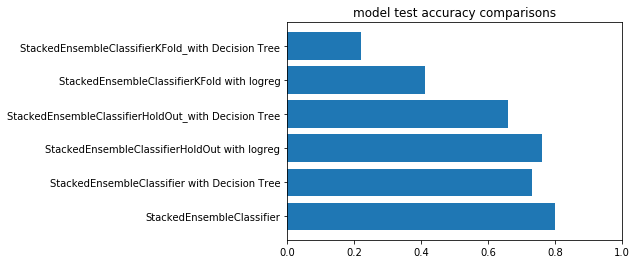

In [22]:
# plot of model test accuracy comparisons
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))
_ = plt.title('model test accuracy comparisons')

{'StackedEnsembleClassifier with logreg': 0.78,
 'StackedEnsembleClassifier with Decision Tree': 0.72,
 'StackedEnsembleClassifierHoldOut with logreg': 0.76,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.69,
 'StackedEnsembleClassifierKFold with logreg': 0.44,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.26}

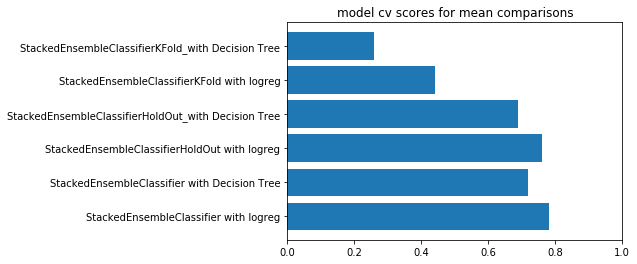

In [23]:
# model cv scores for mean comparisons
display(model_cv_scores_for_mean_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_scores_for_mean_comparisons)), list(model_cv_scores_for_mean_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_scores_for_mean_comparisons)), list(model_cv_scores_for_mean_comparisons.keys()))
_ = plt.title('model cv scores for mean comparisons')

{'StackedEnsembleClassifier with logreg': 0.01,
 'StackedEnsembleClassifier with Decision Tree': 0.0,
 'StackedEnsembleClassifierHoldOut with logreg': 0.01,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.02,
 'StackedEnsembleClassifierKFold with logreg': 0.01,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.0}

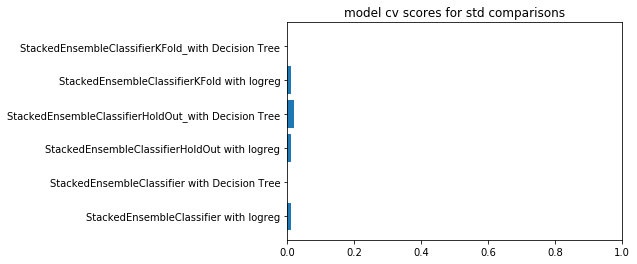

In [24]:
# model cv scores for std comparisons
display(model_cv_scores_for_std_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_scores_for_std_comparisons)), list(model_cv_scores_for_std_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_scores_for_std_comparisons)), list(model_cv_scores_for_std_comparisons.keys()))
_ = plt.title('model cv scores for std comparisons')

## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

In [25]:
'''dataset = pd.read_csv('fashion-mnist_train.csv')
dataset2 = dataset.sample(frac=0.1)
X = dataset2[dataset2.columns.difference(["label"])]
Y = np.array(dataset2["label"])'''

'dataset = pd.read_csv(\'fashion-mnist_train.csv\')\ndataset2 = dataset.sample(frac=0.1)\nX = dataset2[dataset2.columns.difference(["label"])]\nY = np.array(dataset2["label"])'

DECISION TREE

In [26]:
# Set up the parameter grid to seaerch for decision tree
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 20, 3)), \
             'min_samples_split': [50] }

# Perform the grid search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=2, verbose = 0, \
                            return_train_score=True)
my_tuned_tree.fit(X, Y)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)

Best parameters set found on development set:


{'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 50}

In [27]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(test_Y, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["DecisionTreeClassifier"] = accuracy
print("DecisionTreeClassifier Accuracy: " +  str(accuracy))

Accuracy: 0.62
             precision    recall  f1-score   support

          0       0.60      0.30      0.40        10
          1       0.90      0.90      0.90        10
          2       0.75      0.60      0.67        10
          3       0.38      0.30      0.33        10
          4       0.50      0.60      0.55        10
          5       0.88      0.70      0.78        10
          6       0.25      0.40      0.31        10
          7       0.62      1.00      0.77        10
          8       0.89      0.80      0.84        10
          9       0.75      0.60      0.67        10

avg / total       0.65      0.62      0.62       100

Confusion Matrix
DecisionTreeClassifier Accuracy: 0.62


In [28]:
# applying cross validation for DecisionTreeClassifier
scores = cross_val_score(my_tuned_tree, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["DecisionTreeClassifier"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["DecisionTreeClassifier"] = round(np.std(scores),2)

BAGGING

In [29]:
# Set up the parameter grid to search
param_grid = [
 {'n_estimators': list(range(50, 301, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 50)]}
]

cv_folds = 2
# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X, Y)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   3.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   3.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.7min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 250}


In [30]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(test_X)

# Print performance details
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(test_Y, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["BaggingClassifier"] = accuracy
print("BaggingClassifier Accuracy: " +  str(accuracy))

             precision    recall  f1-score   support

          0       0.64      0.70      0.67        10
          1       1.00      0.70      0.82        10
          2       0.53      0.90      0.67        10
          3       0.54      0.70      0.61        10
          4       0.50      0.60      0.55        10
          5       0.89      0.80      0.84        10
          6       0.00      0.00      0.00        10
          7       0.75      0.90      0.82        10
          8       0.90      0.90      0.90        10
          9       0.78      0.70      0.74        10

avg / total       0.65      0.69      0.66       100

Confusion Matrix
BaggingClassifier Accuracy: 0.69


C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
# applying cross validation for BaggingClassifier
scores = cross_val_score(my_tuned_model, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["BaggingClassifier"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["BaggingClassifier"] = round(np.std(scores),2)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   1.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   1.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   44.1s finished


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   0.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   45.3s finished


{'StackedEnsembleClassifier': 0.8,
 'StackedEnsembleClassifier with Decision Tree': 0.73,
 'StackedEnsembleClassifierHoldOut with logreg': 0.76,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.66,
 'StackedEnsembleClassifierKFold with logreg': 0.41,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.22,
 'DecisionTreeClassifier': 0.62,
 'BaggingClassifier': 0.69}

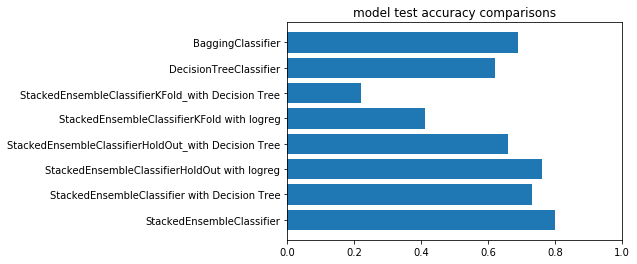

In [32]:
# test accuracy comparisons and plot
display(model_test_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))
_ = plt.title('model test accuracy comparisons')

{'StackedEnsembleClassifier with logreg': 0.78,
 'StackedEnsembleClassifier with Decision Tree': 0.72,
 'StackedEnsembleClassifierHoldOut with logreg': 0.76,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.69,
 'StackedEnsembleClassifierKFold with logreg': 0.44,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.26,
 'DecisionTreeClassifier': 0.64,
 'BaggingClassifier': 0.52}

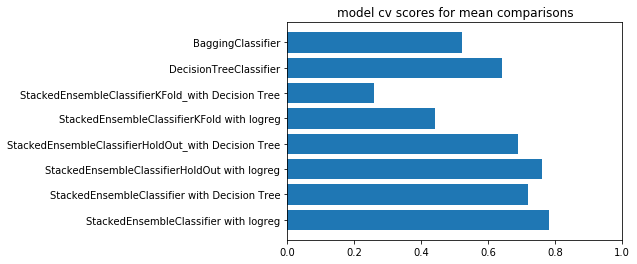

In [33]:
# cv scores for mean comparisons and plot
display(model_cv_scores_for_mean_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_scores_for_mean_comparisons)), list(model_cv_scores_for_mean_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_scores_for_mean_comparisons)), list(model_cv_scores_for_mean_comparisons.keys()))
_ = plt.title('model cv scores for mean comparisons')

{'StackedEnsembleClassifier with logreg': 0.01,
 'StackedEnsembleClassifier with Decision Tree': 0.0,
 'StackedEnsembleClassifierHoldOut with logreg': 0.01,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.02,
 'StackedEnsembleClassifierKFold with logreg': 0.01,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.0,
 'DecisionTreeClassifier': 0.03,
 'BaggingClassifier': 0.01}

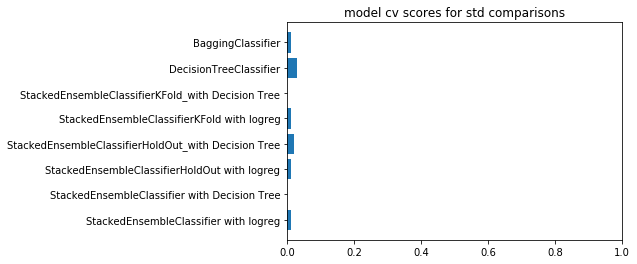

In [34]:
# cv scores for std comparisons and plot
display(model_cv_scores_for_std_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_scores_for_std_comparisons)), list(model_cv_scores_for_std_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_scores_for_std_comparisons)), list(model_cv_scores_for_std_comparisons.keys()))
_ = plt.title('model cv scores for std comparisons')

## Task 5: Implement the StackedEnsembleOneVsOne Class

In [35]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierOneVsOne(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and an aggregation model at the aggregation layer. A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
        
        # Run each type of classifiers 8 times 
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                # Append each classifier (8x3) to the list and create each classifier as we go
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)

        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y
    
        unique_classes = range(0,10)
        
        # i am creating necessary i,j combinations with using for/for/if functions
        for i in range(10):
            for j in range(i):
                if j!=i: 
                    
                    # X1 is subdata of X with label i
                    X1 = X[pd.Index(self.y_stack_train).get_loc(i)]
                    # X2 is subdata of X with label j
                    X2 = X[pd.Index(self.y_stack_train).get_loc(j)]
                    # X_onevsone is combination of X1 and X2
                    X_onevsone = np.concatenate((X1,X2))
                    
                    # Y1 is subdata of Y with label i
                    Y1 = y[pd.Index(self.y_stack_train).get_loc(i)]
                    # Y2 is subdata of Y with label j
                    Y2 = y[pd.Index(self.y_stack_train).get_loc(j)]
                    # y_onevsone is combination of Y1 and Y2
                    y_onevsone = np.concatenate((Y1,Y2))
                    
                    #splitting data
                    X_train_onevsone, X_test_onevsone, y_train_onevsone, y_test_onevsone = train_test_split(X_onevsone, y_onevsone, test_size=0.3) 

                    self.X_stack_train_onevsone = None

                    # Train each base classifier and generate the stack layer training dataset
                    for classifier in self.classifiers_:

                        # Extract a bootstrap sample
                        X_train_samp, y_train_samp = resample(X_train_onevsone, y_train_onevsone, replace=True)    

                        # Train a base classifier
                        classifier.fit(X_train_samp, y_train_samp)

                        # Make predictions for all instances in the test set
                        y_pred_onevsone = classifier.predict_proba(X) #### Changed so it predicts values for the test set instead of train set

                        # Append the predictions to the stack layer training set (a bit of hacking here!)
                        # We are using the y predictions as the new training data in the stack layer 
                        try:
                            self.X_stack_train_onevsone = np.c_[self.X_stack_train_onevsone, y_pred_onevsone]
                        except ValueError:
                            self.X_stack_train_onevsone = y_pred_onevsone

                            
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train_onevsone, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred_onevsone

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

In [36]:
# applying StackedEnsembleClassifierOneVsOne with logreg
clf = StackedEnsembleClassifierOneVsOne()
clf.fit(X, Y)
y_pred = clf.predict(test_X)
print(metrics.classification_report(test_Y, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifierOneVsOne with logreg"] = accuracy
print("StackedEnsembleClassifierOneVsOne with logreg Accuracy: " +  str(accuracy))

             precision    recall  f1-score   support

          0       0.40      0.40      0.40        10
          1       0.50      0.30      0.37        10
          2       0.50      0.20      0.29        10
          3       0.42      0.50      0.45        10
          4       0.23      0.90      0.36        10
          5       0.83      0.50      0.62        10
          6       0.00      0.00      0.00        10
          7       0.62      0.80      0.70        10
          8       0.00      0.00      0.00        10
          9       0.89      0.80      0.84        10

avg / total       0.44      0.44      0.40       100

Confusion Matrix


C:\Users\aksunbul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,0,1,2,3,4,5,7,9,All
True,,,,,,,,,
0,4,0,0,0,6,0,0,0,10
1,1,3,0,4,2,0,0,0,10
2,2,0,2,1,5,0,0,0,10
3,1,3,0,5,1,0,0,0,10
4,0,0,1,0,9,0,0,0,10
5,0,0,0,2,0,5,3,0,10
6,2,0,1,0,7,0,0,0,10
7,0,0,0,0,0,1,8,1,10
8,0,0,0,0,10,0,0,0,10


StackedEnsembleClassifierOneVsOne with logreg Accuracy: 0.44


In [37]:
# applying cross validation for StackedEnsembleClassifierOneVsOne with logreg
scores = cross_val_score(clf, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["StackedEnsembleClassifierOneVsOne with logreg"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["StackedEnsembleClassifierOneVsOne with logreg"] = round(np.std(scores),2)

In [38]:
# applying StackedEnsembleClassifierOneVsOne with tree
clf = StackedEnsembleClassifierOneVsOne(stack_layer_classifier_type = "tree")
clf.fit(X, Y)
y_pred = clf.predict(test_X)
print(metrics.classification_report(test_Y, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Print performance details
accuracy = round(metrics.accuracy_score(test_Y, y_pred),2) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifierOneVsOne with Decision Tree"] = accuracy
print("StackedEnsembleClassifierOneVsOne with Decision Tree Accuracy: " +  str(accuracy))

             precision    recall  f1-score   support

          0       0.38      0.30      0.33        10
          1       0.33      0.30      0.32        10
          2       0.27      0.30      0.29        10
          3       0.36      0.50      0.42        10
          4       0.25      0.40      0.31        10
          5       0.86      0.60      0.71        10
          6       0.20      0.20      0.20        10
          7       0.67      0.80      0.73        10
          8       1.00      0.30      0.46        10
          9       0.90      0.90      0.90        10

avg / total       0.52      0.46      0.47       100

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,3,1,0,1,4,0,1,0,0,0,10
1,0,3,1,6,0,0,0,0,0,0,10
2,1,0,3,0,3,0,3,0,0,0,10
3,0,4,0,5,0,0,1,0,0,0,10
4,1,0,4,0,4,0,1,0,0,0,10
5,0,0,0,1,0,6,0,3,0,0,10
6,3,1,1,1,2,0,2,0,0,0,10
7,0,0,0,0,0,1,0,8,0,1,10
8,0,0,2,0,3,0,2,0,3,0,10


StackedEnsembleClassifierOneVsOne with Decision Tree Accuracy: 0.46


In [39]:
# applying cross validation for StackedEnsembleClassifierOneVsOne with tree
scores = cross_val_score(clf, X, Y, cv=2)
# print(scores)
# print(np.mean(scores), " +/- ", np.std(scores))
model_cv_scores_for_mean_comparisons["StackedEnsembleClassifierOneVsOne with Decision Tree"] = round(np.mean(scores),2)
model_cv_scores_for_std_comparisons["StackedEnsembleClassifierOneVsOne with Decision Tree"] = round(np.std(scores),2)

## Task 6 Evaluate the Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

{'StackedEnsembleClassifier': 0.8,
 'StackedEnsembleClassifier with Decision Tree': 0.73,
 'StackedEnsembleClassifierHoldOut with logreg': 0.76,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.66,
 'StackedEnsembleClassifierKFold with logreg': 0.41,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.22,
 'DecisionTreeClassifier': 0.62,
 'BaggingClassifier': 0.69,
 'StackedEnsembleClassifierOneVsOne with logreg': 0.44,
 'StackedEnsembleClassifierOneVsOne with Decision Tree': 0.46}

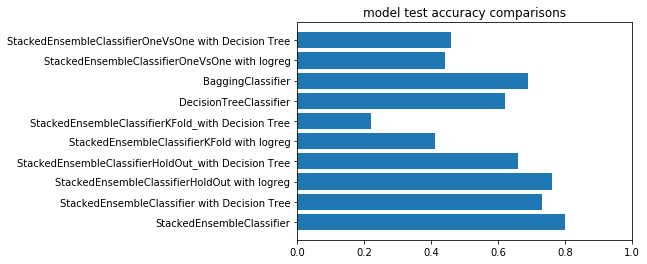

In [40]:
# the comparison of performance of all algorithms wrt accuracy results  
display(model_test_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))
_ = plt.title('model test accuracy comparisons')

{'StackedEnsembleClassifier with logreg': 0.78,
 'StackedEnsembleClassifier with Decision Tree': 0.72,
 'StackedEnsembleClassifierHoldOut with logreg': 0.76,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.69,
 'StackedEnsembleClassifierKFold with logreg': 0.44,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.26,
 'DecisionTreeClassifier': 0.64,
 'BaggingClassifier': 0.52,
 'StackedEnsembleClassifierOneVsOne with logreg': 0.47,
 'StackedEnsembleClassifierOneVsOne with Decision Tree': 0.48}

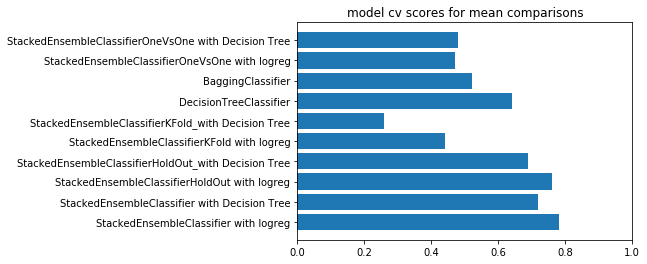

In [41]:
# the comparison of performance of all algorithms wrt cv mean results 
display(model_cv_scores_for_mean_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_scores_for_mean_comparisons)), list(model_cv_scores_for_mean_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_scores_for_mean_comparisons)), list(model_cv_scores_for_mean_comparisons.keys()))
_ = plt.title('model cv scores for mean comparisons')

{'StackedEnsembleClassifier with logreg': 0.01,
 'StackedEnsembleClassifier with Decision Tree': 0.0,
 'StackedEnsembleClassifierHoldOut with logreg': 0.01,
 'StackedEnsembleClassifierHoldOut_with Decision Tree': 0.02,
 'StackedEnsembleClassifierKFold with logreg': 0.01,
 'StackedEnsembleClassifierKFold_with Decision Tree': 0.0,
 'DecisionTreeClassifier': 0.03,
 'BaggingClassifier': 0.01,
 'StackedEnsembleClassifierOneVsOne with logreg': 0.02,
 'StackedEnsembleClassifierOneVsOne with Decision Tree': 0.01}

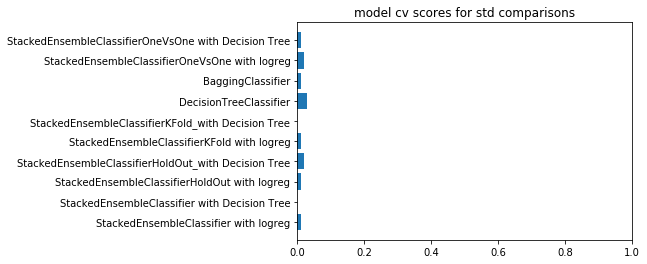

In [42]:
# the comparison of performance of all algorithms wrt cv std results 
display(model_cv_scores_for_std_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_scores_for_std_comparisons)), list(model_cv_scores_for_std_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_scores_for_std_comparisons)), list(model_cv_scores_for_std_comparisons.keys()))
_ = plt.title('model cv scores for std comparisons')

## Task 7 Reflect on the Performance of the Different Models Evaluated

I have worked with 10 different models. These models are formed with logreg and decision tree applications on stack layer for StackedEnsembleClassifier, StackedEnsembleClassifierHoldOut, StackedEnsembleClassifierKFold and StackedEnsembleClassifierOneVsOne. The other two models are application of simple decision tree and bagging classifier. 

I have applied grid search for both decision tree classifier and bagging classifier to find best model parameters.Then used these tuned models to observe the success rates of the decision tree classifier and bagging classifier.

Also, I have cross validated all of 10 different models with cv number is 2. I have found the mean and standard deviation for each and take average of them. Used these averages to compare the performances of the models. 

Another and the most important performance criteria I have used to compare 10 different models is accuracy rates of the models. I have created graphs for mean and std of cross validations and accuracy rates to make easily understandable the results.

For model performance, as we see from the accuracy results, if logistic regression is applied on stack layer for kFold, Holdout and original ensemble  cases, better accuracy rates are obtained. I have run the code several times and observed same kind of results every time. In this case, I have fit the algorithms with 1000 rows and tested for 100 rows. These sample datasets were obtained by looking for equal stratification which means I have 100 and 10 samples from each class for training and test datasets, respectively.

We see parallel results for mean values of cross validation results with accuracy rates and don't observe higher standard  deviations.

For computational requirements and model complexity, Kfold has to handle more works when it is compared holdout and original ensemble cases. Since, it runs whole things for K times. However, it does not create better results for this kind of effort. The size of data can be increased to increase Kfold success. Also, OnevsOne case spends very much effort according to others. But, again it creates worse accuracy rates that holdout and original ensemble cases. In OnevsOne case, the reason can be creating useless data for stack layer, because I predict whole X with the fitted model of each pair.